In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/NLU

/content/drive/MyDrive/NLU


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Thu Apr 21 01:27:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
pip install transformers

In [5]:
pip install datasets

In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer, RobertaForSequenceClassification, RobertaForQuestionAnswering
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from transformers import AdamW
import random
from IPython.display import clear_output

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
import datasets

In [9]:
pip install Sentencepiece

In [10]:
# from datasets import load_dataset
# dataset = load_dataset('banking77')
# print(dataset)

In [11]:
import pandas as pd
train_dataset = pd.read_csv("/content/drive/MyDrive/NLU/train.csv")
test_dataset = pd.read_csv("/content/drive/MyDrive/NLU/test.csv")
print(train_dataset, test_dataset)

                                                    text         category
0                         I am still waiting on my card?     card_arrival
1      What can I do if my card still hasn't arrived ...     card_arrival
2      I have been waiting over a week. Is the card s...     card_arrival
3      Can I track my card while it is in the process...     card_arrival
4      How do I know if I will get my card, or if it ...     card_arrival
...                                                  ...              ...
9998              You provide support in what countries?  country_support
9999                  What countries are you supporting?  country_support
10000                What countries are getting support?  country_support
10001                     Are cards available in the EU?  country_support
10002                   Which countries are represented?  country_support

[10003 rows x 2 columns]                                                    text         category
0            

In [12]:
len(train_dataset["text"])

10003

In [13]:
idx = np.arange(len(train_dataset["text"]))
print(idx)

[    0     1     2 ... 10000 10001 10002]


In [14]:
# preprocess for training 
train_data = []
train_labels = []
for i in range(len(train_dataset)):
  train_data.append(train_dataset["text"][i])
  train_labels.append(train_dataset["category"][i])


test_data = []
test_labels = []
for i in range(len(test_dataset)):
  test_data.append(test_dataset["text"][i])
  test_labels.append(test_dataset["category"][i])

train_dict = {
  "text": train_data,
  "label": train_labels
}

test_dict = {
  "text": test_data,
  "label": test_labels
}

print("Train Dict")
print(train_dict.keys())
print(train_dict['text'][:2])
print(train_dict['label'][:2])

print("\nTest Dict")
print(test_dict.keys())
print(test_dict['text'][:2])
print(test_dict['label'][:2])

Train Dict
dict_keys(['text', 'label'])
['I am still waiting on my card?', "What can I do if my card still hasn't arrived after 2 weeks?"]
['card_arrival', 'card_arrival']

Test Dict
dict_keys(['text', 'label'])
['How do I locate my card?', 'I still have not received my new card, I ordered over a week ago.']
['card_arrival', 'card_arrival']


In [15]:
train_data = []
train_labels = []

test_data = []
test_labels = []

# preprocess for training 
for i in range(len(train_dict['text'])):
    train_data.append(train_dict['text'][i])
    train_labels.append(train_dict['label'][i])
      
# write code here : preprocess test samples
for i in range(len(test_dict['text'])):
    test_data.append(test_dict['text'][i])
    test_labels.append(test_dict['label'][i])

In [16]:
print(train_data)
print(train_labels)
print(len(train_data))
print(len(train_labels))

['I am still waiting on my card?', "What can I do if my card still hasn't arrived after 2 weeks?", 'I have been waiting over a week. Is the card still coming?', 'Can I track my card while it is in the process of delivery?', 'How do I know if I will get my card, or if it is lost?', 'When did you send me my new card?', 'Do you have info about the card on delivery?', 'What do I do if I still have not received my new card?', 'Does the package with my card have tracking?', "I ordered my card but it still isn't here", 'Why has my new card still not come?', "I still haven't received my card after two weeks, is it lost?", 'Can you track my card for me?', 'Is there a way to track the delivery of my card?', "It's been a week since I ordered my card and it's not here. Please help?", 'Will I be able to track the card that was sent to me?', "I don't have my card in 1 week.  Should I be worried?", 'How do I know when my new card is going to arrive?', 'My new card has not been delivered to my home ye

In [17]:
# train_data_ = train_data[:8002]
# val_data_ = train_data[8002:]

# train_label_ = train_labels[:8002]
# val_label_ = train_labels[8002:]

# print("Text")
# print(len(train_data_))
# print(len(val_data_))
# print(len(train_data_) + len(val_data_))

# print("\nLabel")
# print(len(train_label_))
# print(len(val_label_))
# print(len(train_label_) + len(val_label_))

In [18]:
# #Check if val data is correct
# print(val_data_[-1])
# print(train_data[-1])

In [19]:
# create custom dataset class
# ===  =  Hint =  ===
# can train on two condition 
# 1.) trainig training with supervise contrastive loss and cross entropy loss using in question 5.) 
#    when self.repeated_label == True:
# 2.) train only cross entropy loss use in question 4.)
#    when self.repeated_label == False:
class CustomTextDataset(Dataset):
    def __init__(self,labels,text,batch_size,repeated_label:bool=False):
        self.labels = labels
        self.text = text
        self.batch_size = batch_size 
        self.count = 0 
        self.repeated_label = repeated_label
        
        # to use when training with supervise contrastive loss
        if self.repeated_label == True:
           # write the code here
            self.exist_classes = [] 
            self.label_maps = None 
            self.ids_maps = []
            self.len_data = len(self.labels)
            self.count_batch = 0 
            self.is_left_batch = False

            #print("self.len_data ",self.len_data)
            #print("self.len data",self.batch_size)

            self.max_count = self.len_data // self.batch_size 

            if self.len_data % self.batch_size !=0:
                self.max_count += 1 

            print("the number of maximum of batching :",self.max_count)
            pass
          

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        # write code here for 1)
        if self.repeated_label == True:
            self.count +=1  
            # it would be clear after call til batch_size  
            self.exist_classes.append(self.labels[idx])
            self.ids_maps.append(idx)


            if self.count_batch == self.max_count - 1:
                self.count_batch = +1 
                #print("self.count_batch :",self.count_batch)
                self.count_batch = 0 

                if self.len_data % self.batch_size !=0: 
                    self.batch_size = self.len_data % self.batch_size
                    self.is_left_batch = True

                #print("change batch size !",self.batch_size)
                #print("LAST batching !")

            if self.count == self.batch_size:

                unique_labels_keys = list(set(self.exist_classes))
                table = [0] * len(unique_labels_keys)
                unique_labels = dict(zip(unique_labels_keys,table))
                
                if self.is_left_batch == True:
                    self.is_left_batch = False
                    self.batch_size = 16  

                else: 
                    self.count_batch += 1
                    #print("count_batch :",self.count_batch)
                
                for class_key in self.exist_classes:
                    unique_labels[class_key] = +1 

                #print("tables of each labels :",unique_labels)

                for index, key  in enumerate(unique_labels):

                    if unique_labels[key] > 1:
                        print("v>1 :",unique_labels[key])
                        break

                    
                    if index == len(unique_labels.keys()) - 1:
                        while True:
                            pos_idx = random.randint(0,self.len_data-1) 
                            if self.labels[pos_idx] in unique_labels.keys():
                                if self.labels[pos_idx] == self.labels[idx]:
                                    pass
                                else:
                                   #print("old idx :",idx,self.labels[idx])
                                    idx = pos_idx
                                   #print("new idx :",idx,self.labels[idx])
                                    unique_labels[self.labels[idx]] +=1  
                                   #print("statistics tables :",unique_labels)
                                   # replace last token
                                    self.exist_classes[-1] = self.labels[idx]
                                    if len(set(self.exist_classes)) ==  len(self.exist_classes):
                                        print("unique_labels:")
                                        #print(unique_labels)

                                    self.count = 0  
                                    self.exist_classes = [] 
                                    self.ids_maps = []
                                
                                    break 
            

         
        label = self.labels[idx]
        
        data = self.text[idx]
        
        sample = {"Class": label,"Text": data}


    
        return sample

In [20]:
from torch.utils.data import Dataset, DataLoader

In [21]:
batch_size = 4
embed_dim = 768

# dataloader for training 
print("Train")
c_train_data = CustomTextDataset(train_labels,train_data,batch_size=batch_size,repeated_label=True)
train_loader = DataLoader(c_train_data,batch_size=batch_size,shuffle=True)

print("Test")
c_test_data = CustomTextDataset(test_labels,test_data,batch_size=batch_size,repeated_label=True)
test_loader = DataLoader(c_test_data,batch_size=batch_size,shuffle=True)

Train
the number of maximum of batching : 2501
Test
the number of maximum of batching : 770


In [22]:
# batch_size = 64
# # dataloader for training 
# print("Train")
# c_train_data = CustomTextDataset(train_label_,train_data_,batch_size=batch_size,repeated_label=True)
# train_loader = DataLoader(c_train_data,batch_size=batch_size,shuffle=True)

# print("Val")
# c_val_data = CustomTextDataset(val_label_,val_data_,batch_size=batch_size,repeated_label=True)
# train_loader = DataLoader(c_val_data,batch_size=batch_size,shuffle=True)

# print("Test")
# c_test_data = CustomTextDataset(test_labels,test_data,batch_size=batch_size,repeated_label=True)
# test_loader = DataLoader(c_test_data,batch_size=batch_size,shuffle=True)

In [23]:
for (idx, batch) in enumerate(train_loader):
    idx = idx
    sentence = batch['Text']
print(sentence)
print(idx)
print(len(sentence))

['When will the money reach my  account?', 'I did a cash deposit to my account, but I am not seeing it on my statement.', "Why hasn't my transfer from Europe gone through?"]
2500
3


In [24]:
# got the number of unique classes from dataset
num_class = len(np.unique(np.array(train_dict['label'])))

# get text label of uniqure classes
unique_label = np.unique(np.array(train_dict['label']))

# map text label to index classes
label_maps = {unique_label[i]: i for i in range(len(unique_label))}

In [25]:
print("Num class:", num_class)
print("Unique label:", unique_label[:5])
print(label_maps)

Num class: 77
Unique label: ['Refund_not_showing_up' 'activate_my_card' 'age_limit'
 'apple_pay_or_google_pay' 'atm_support']
{'Refund_not_showing_up': 0, 'activate_my_card': 1, 'age_limit': 2, 'apple_pay_or_google_pay': 3, 'atm_support': 4, 'automatic_top_up': 5, 'balance_not_updated_after_bank_transfer': 6, 'balance_not_updated_after_cheque_or_cash_deposit': 7, 'beneficiary_not_allowed': 8, 'cancel_transfer': 9, 'card_about_to_expire': 10, 'card_acceptance': 11, 'card_arrival': 12, 'card_delivery_estimate': 13, 'card_linking': 14, 'card_not_working': 15, 'card_payment_fee_charged': 16, 'card_payment_not_recognised': 17, 'card_payment_wrong_exchange_rate': 18, 'card_swallowed': 19, 'cash_withdrawal_charge': 20, 'cash_withdrawal_not_recognised': 21, 'change_pin': 22, 'compromised_card': 23, 'contactless_not_working': 24, 'country_support': 25, 'declined_card_payment': 26, 'declined_cash_withdrawal': 27, 'declined_transfer': 28, 'direct_debit_payment_not_recognised': 29, 'disposable_car

Tokenizing

In [26]:
# from transformers import XLNetConfig, XLNetTokenizer, XLNetForSequenceClassification

In [27]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [28]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# print(device)

In [29]:
# config = XLNetConfig.from_pretrained("xlnet-base-cased",output_hidden_states=True)
config = RobertaConfig.from_pretrained("roberta-base",output_hidden_states=True)

#chnage modifying the number of classes
config.num_labels = num_class

# tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
model = RobertaForSequenceClassification.from_pretrained("roberta-base")

# change from binary classification to muli-classification and loss automatically change to cross entropy loss
model.num_labels = config.num_labels

# # change the output of last layer to num_class that we want to predict
model.classifier.out_proj = nn.Linear(in_features=embed_dim,out_features=num_class)

# move to model to device that we set
model = model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [30]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [31]:
# embed_dim = 768

# change the output of last layer to num_class that we want to predict
model.logits_proj = nn.Linear(in_features=embed_dim,out_features=num_class)
model = model.to(device)

print(model)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [32]:
# from transformers import AdamW

lr= 1e-5 
optimizer= torch.optim.AdamW(model.parameters(), lr=lr)

In [33]:
# inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
# labels = torch.tensor([[1, 1]], dtype=torch.float)
# print(inputs['input_ids'].size())
# print(labels.size())

In [34]:
for batch_sub in enumerate(batch):
  print(batch_sub)
  # inputs = tokenizer(batch_sub['Text'], return_tensors="pt")
  # labels = torch.tensor(batch_sub['Class']).unsqueeze(0)  # Batch size 1

(0, 'Class')
(1, 'Text')


In [35]:
# 4.3
# this code training models on Cross entropy loss
train_loss = []
train_accuracy = []
best_train_loss = float('inf')
total_acc_train = 0
n_correct = 0 
n_wrong = 0


for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    
    for (idx, batch) in enumerate(train_loader):
        sentence = batch["Text"]
        inputs = tokenizer(sentence, padding=True,truncation=True,return_tensors="pt")
        
        # move parameter to device
        inputs = {k:v.to(device) for k,v in inputs.items()}

        # map string labels to class idex

        labels = [label_maps[stringtoId] for stringtoId in (batch['Class'])]
                    
        #print("show out: ",np.unique(labels, return_counts=True))
        # convert list to tensor
        labels = torch.tensor(labels).unsqueeze(0)
        labels = labels.to(device)
#         print(labels)

        #(batch_size, seq_len)
        #print(inputs["input_ids"].shape)

         # zero the parameter gradients
        optimizer.zero_grad()

        outputs = model(**inputs,labels=labels)
        # you can check 
        loss, logits = outputs[:2]
        
        loss.backward()
        optimizer.step()

        # write code here 
        pred_class = torch.argmax(logits)
#         print(pred_class)
        if pred_class in labels:
            n_correct += 1
        else:
            n_wrong += 1
        total_acc_train = (n_correct * 1.0) / (n_correct + n_wrong)
        
        train_loss.append(loss.item())
        train_accuracy.append(total_acc_train)
        
        # to save model eg. model.pth look at pytorch document how to save model
        if loss.item() < best_train_loss:
            best_train_loss = loss.item()
            torch.save(model.state_dict(), 'roberta-model.pt')
        
        print(f'[Epoch: {epoch + 1}, {idx}] \nTrain loss: {loss.item():.2f} \nTrain Acc: {total_acc_train*100:.2f} %')
        clear_output(wait=True)

[Epoch: 1, 2500] 
Train loss: 1.00 
Train Acc: 21.27 %


In [36]:
import pickle

with open("train_loss", "wb") as fp:   #Pickling
  pickle.dump(train_loss, fp)

with open("train_accuracy", "wb") as fp:   #Pickling
  pickle.dump(train_accuracy, fp)

Text(0, 0.5, 'acc')

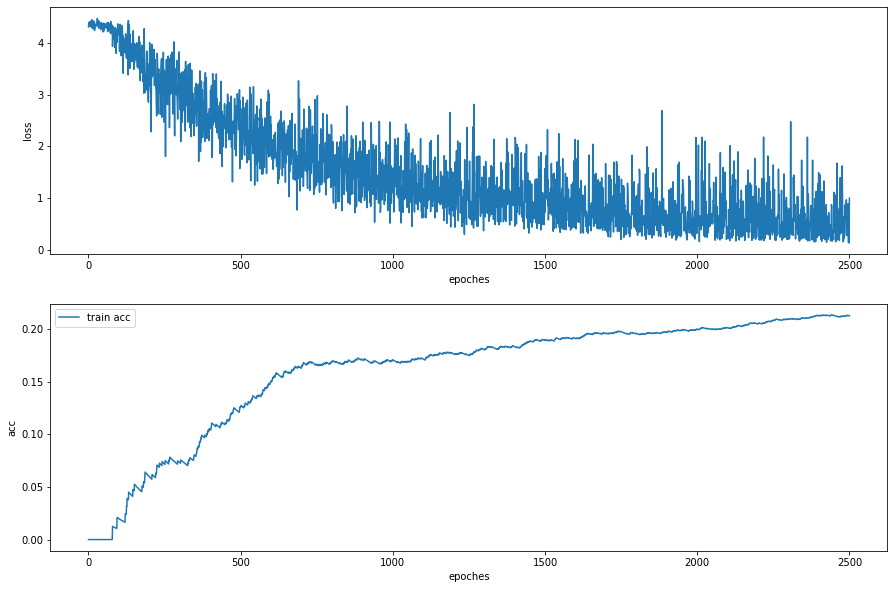

In [37]:
# write code here for 4.5
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(train_loss, label = 'train loss')
ax2.plot(train_accuracy, label = 'train acc')
plt.legend()
ax1.set_xlabel('epoches')
ax1.set_ylabel('loss')
ax2.set_xlabel('epoches')
ax2.set_ylabel('acc')


In [38]:
#4.6
model.load_state_dict(torch.load('roberta-model.pt'))
# this code training models on Cross entropy loss

test_loss = []
test_accuracy = []
total_acc_test = 0
n_correct = 0 
n_wrong = 0

# #for epoch in range(30):  # loop over the dataset multiple times
for epoch in range(1):# loop over the dataset multiple times
    
    running_loss = 0.0
    with torch.no_grad():
        for (idx, batch) in enumerate(test_loader):
            sentence = batch["Text"]
            inputs = tokenizer(sentence,padding=True,truncation=True,return_tensors="pt")

            # move parameter to device
            inputs = {k:v.to(device) for k,v in inputs.items()}

            # map string labels to class idex
            labels = [label_maps[stringtoId] for stringtoId in (batch['Class'])]

            #print("show out: ",np.unique(labels, return_counts=True))
            # convert list to tensor
            labels = torch.tensor(labels).unsqueeze(0)
            labels = labels.to(device)


            #(batch_size, seq_len)
            #print(inputs["input_ids"].shape)

             # zero the parameter gradients
            # optimizer.zero_grad()

            outputs = model(**inputs,labels=labels)
            # you can check 
            loss, logits = outputs[:2]

            # loss.backward()
            # optimizer.step()
            pred_class = torch.argmax(logits)
#         print(pred_class)
            if pred_class in labels:
                n_correct += 1
            else:
                n_wrong += 1
            total_acc_test = (n_correct * 1.0) / (n_correct + n_wrong)

            test_loss.append(loss.item())
            test_accuracy.append(total_acc_test)



            print(f'[Epoch: {epoch + 1}, {idx}] \nTest loss: {loss.item():.2f} \nTest Acc: {total_acc_test*100:.2f} %')
            
            print(running_loss)  
            clear_output(wait=True)

[Epoch: 1, 769] 
Test loss: 0.55 
Test Acc: 25.19 %
0.0


In [39]:
import pickle

with open("test_loss", "wb") as fp:   #Pickling
  pickle.dump(test_loss, fp)

with open("test_accuracy", "wb") as fp:   #Pickling
  pickle.dump(test_accuracy, fp)

Text(0, 0.5, 'acc')

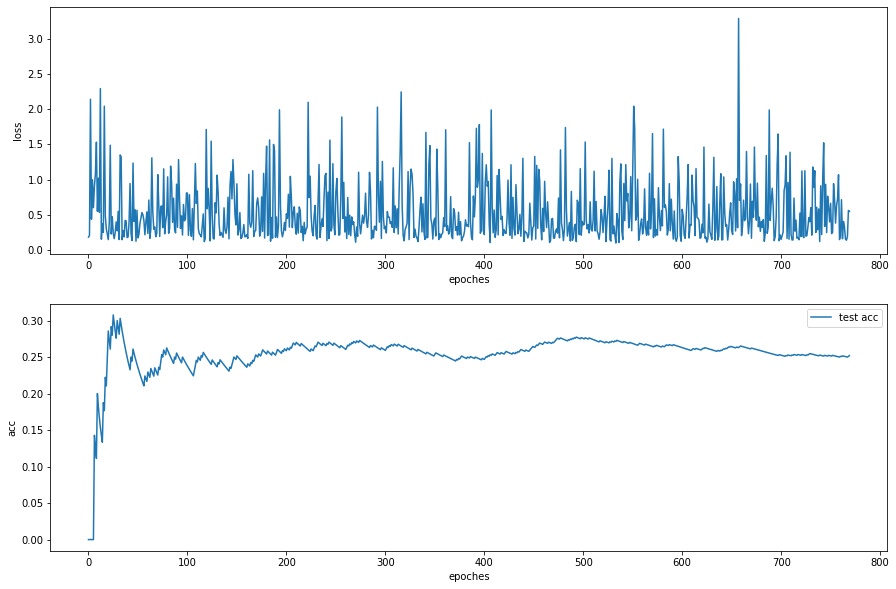

In [40]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(test_loss, label = 'test loss')
ax2.plot(test_accuracy, label = 'test acc')
plt.legend()
ax1.set_xlabel('epoches')
ax1.set_ylabel('loss')
ax2.set_xlabel('epoches')
ax2.set_ylabel('acc')


In [41]:
import torch
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification

from transformers import AutoModel, AutoTokenizer
import random
import torch.nn as nn
import torch.nn.functional as F
from numpy import ndarray
from typing import List, Dict, Tuple, Type, Union
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
import numpy as np
from transformers import RobertaTokenizer
import random


class Similarity(nn.Module):
    """
    Dot product or cosine similarity
    """

    def __init__(self, temp=None):
        super().__init__()

        if temp !=None:
            self.temp = temp
        else: 

            self.temp = 1.0
        # among feature last dim 
        self.cos = nn.CosineSimilarity(dim=-1)

    def forward(self, x, y):
        
        return  self.cos(x, y) / self.temp


def create_supervised_pair(h,labels,debug:bool=False):
    

    """
     h - (batch_size, seq_len, hidden_dim)
     label - (batch_size) 
    
    """
    # params
    h_i = [] # pos pairs
    h_j = [] # neg pairs
    skips = []
    idx_i = [] # index yi = yj

    # proof done 
    # masking correct
    # pair of concat correct

    T = 0 # the numbers of pairs sample
    
    for idx, label in enumerate(labels): 

        if idx in skips:
            continue

        mask = label == np.array(labels)
        
        # dont include current sample 
        mask[idx] = False 
        
        # check is they have pos pair 
        if np.count_nonzero(mask) >= 1:
            

            idxs_arr = np.arange(len(labels))
            # each h_i and h_j :  (sample, hidden_dim)
            
            # (hidden_dim)
            h_i_tensor = h[idx,:] # got 1 dim 
            # (1,hidden_dim)
            h_i_tensor = h_i_tensor[None,:] # got 2 dim 
            
            # preparing to broadcast up to # repeated labels
            h_i_tensor = h_i_tensor.repeat(np.count_nonzero(mask),1)

            
            #print("h_j idx :",h[mask,:,:].shape)
            # (seq_len,hidden_dim) , (#pairs, hidden_dim)
            if debug:
                if np.count_nonzero(mask) >= 2:
                    print("----")
                    print("masking label debug :",np.array(labels)[mask])
                    print("current labels ",np.array(labels)[idx])
                    print("---")
                
                print(">>>>>>>>>>>>>")
                print("repeat for broadcast :",h_i_tensor.shape)
                print("before append h_i and h_j")
                print("h_i : ",h_i_tensor.shape)
                print("h_j : ",h[mask,:].shape)


            # proof masking are correct they select the same class 
            h_i.append(h_i_tensor)
            h_j.append(h[mask,:])


            for val in idxs_arr[mask]: 
                skips.append(val)
            # add pair numbers of samples 

            # copy sample i to #of pairs
            for i in range(np.count_nonzero(mask)):
                idx_i.append(idx)

            T+= np.count_nonzero(mask)
            
            if debug:
                
                print("idx:",idx)
                print("current skips :",idxs_arr[mask])
                print("current labels :",label)

                label_arr = np.array(labels)

                 
                print("pair class :",label_arr[mask])
                print("mask:", mask)
                print("count:",len(mask))
                print("numbers of pairs one label :",np.count_nonzero(mask))
           
    
    if h_i:
    # after ending loop 
        h_i = torch.cat(h_i,dim=0)
        h_j = torch.cat(h_j,dim=0)    
    
        
        """
        print("all the sample i :",idx_i)
        print("skips :",skips)
        print("h_i shape :",h_i.shape)
        print("the number of pairs :",T)
        """
    
        if debug: 

            print("the number of pairs for entire batch:",T) 
            print("pairs see from labels : ",len(labels)-len(set(labels)))
    


        return T, h_i, h_j, idx_i
    else:

        return T, None, None, None
    
    

def supervised_contrasive_loss(h_i:Tensor,h_j:Tensor,h_n:Tensor,T:int,temp,idx_yij:List,callback=None,debug=False)->Union[ndarray, Tensor]:
    """
    T - number of pairs from the same classes in batch
    
    pos_pair - two utterances from the same class
    
    * remark previous work treat the utterance and itself as pos_pair
    neg_pair - two utterances across different class  
   
    """
    sim = Similarity(temp)
    
    device = "cuda:0"


    if callback != None:
       
       h_i = callback(h_i)
       h_j = callback(h_j)
       h_n = callback(h_n)
           
    # exp(sim(a,b)/ temp)

    pos_sim = torch.exp(sim(h_i,h_j))
     
    # for collect compute  sum_batch(exp(sim(hi,hn)/t)) 
    bot_sim  = []

    # masking bottom
    # same batch size shape
    #mask = np.arange(h_n.shape[0])

    """
    print("idxes yi=yj :",idx_yij)
    print("len yij",len(idx_yij))
    print("mask :",mask)
    print("# hi:  ",h_i.shape[0])
    """
    for idx in range(h_i.shape[0]):
       

        #mask = mask != idx_yij[idx]

        #h_n_neg = h_n[mask,:]
        # create h_i equal h_n_neg.shape[0] copies

        # select current sample from list pos pairs
        h_i_broad = h_i[idx].repeat(h_n.shape[0],1)
        

        if debug:
            print("h_i before broad :",h_i[idx].shape)
            print("after broad h_i to h_n",h_i_broad.shape)
            print("h_n shape :",h_n.shape)
        

        # sum over batch
        res = torch.sum(torch.exp(sim(h_i_broad,h_n))) 
        
        if debug:
            print("sim(h_i,h_n) shape :",res.shape)
            print("neg_sim max_min :",res.max(), res.min())
         
   
        if debug:
            print("after summing bottom factor :",res.shape)


        # to use with each pair i and j 
        bot_sim.append(res)

    bot_sim = torch.Tensor(bot_sim).to(device)

    if debug:
        print("bot_sim :",bot_sim.shape)
        print("pos_sim.shape :",pos_sim.shape)     
    
       

    if debug:
        print("bot sim :",bot_sim.shape)
        print("pos sim :",pos_sim.shape)
    
    
    loss = torch.log((pos_sim/bot_sim))
    
    
    loss = torch.sum(loss)

    if debug:
        print("after take log: ",loss)
    
    loss = -loss / T   

    
    return loss


In [42]:
train_loss_5 = []
train_acc_5 = []
n_correct = 0 
n_wrong = 0
best_train_loss = float('inf')
skip_time = 0 # the number of time that yi not equal to yj in supervised contrastive loss equation 
temp = 0.5  # adjustable
lamda = 0.02  # adjustable 

for epoch in range(1):  # loop over the dataset multiple times
    
    running_loss = 0.0
    
    for (idx, batch) in enumerate(train_loader):
        sentence = batch["Text"]
        inputs = tokenizer(sentence,padding=True,truncation=True,return_tensors="pt")
        inputs = {k:v.to(device) for k,v in inputs.items()}

        # map string labels to class idex
        labels = [label_maps[stringtoId] for stringtoId in (batch['Class'])]

        
        # convert list to tensor
        labels = torch.tensor(labels).unsqueeze(0)
        labels = labels.to(device)


        #(batch_size, seq_len)
        #print(inputs["input_ids"].shape)

         # zero the parameter gradients
        optimizer.zero_grad()

        outputs = model(**inputs,labels=labels,output_hidden_states=True)     
        
        hidden_states = outputs.hidden_states
        
        last_hidden_states = hidden_states[12]
        
        # https://stackoverflow.com/questions/63040954/how-to-extract-and-use-bert-encodings-of-sentences-for-text-similarity-among-sen 
        # (batch_size,seq_len,embed_dim)
        h = last_hidden_states[:,0,:]
        
        # create pair samples
        T, h_i, h_j, idx_yij = create_supervised_pair(h,batch['Class'],debug=False)
        
        if h_i is None:
            print("skip this batch")
            skip_time +=1
            continue
               
        # supervised contrastive loss 
        loss_s_cl = supervised_contrasive_loss(h_i, h_j, h, T,temp=temp,idx_yij=idx_yij,debug=False)
        
        # cross entropy loss
        loss_classify, logits = outputs[:2]
        
        # loss total
        loss = loss_s_cl + (lamda * loss_classify)
        
        loss.backward()
        optimizer.step()
        
        
        pred_class = torch.argmax(logits)
#         print(pred_class)
        if pred_class in labels:
            n_correct += 1
        else:
            n_wrong += 1
        total_acc_train = (n_correct * 1.0) / (n_correct + n_wrong)
        
        train_loss_5.append(loss.item())
        train_acc_5.append(total_acc_train)
#         print(f'[{epoch + 1}, {idx}] loss_total: {loss.item()}, loss_s_cl:{loss_s_cl.item()}, loss_classify:{lamda * loss_classify.item()}')
        # to save model eg. model.pth look at pytorch document how to save model
        if loss.item() < best_train_loss:
            best_train_loss = loss.item()
            torch.save(model.state_dict(), 'roberta-model_with_supervised_contrasive_loss.pt')
        print(f'[{epoch + 1}, {idx}] \nloss_total: {loss.item():.2f}, \nloss_s_cl:{loss_s_cl.item():.2f}, \nloss_classify:{lamda * loss_classify.item():.2f}, \nTrain_accuracy: {total_acc_train*100:.2f} %')
        clear_output(wait=True)  

# print(f'[{epoch + 1}, {idx}] \nloss_total: {loss.item():.2f}, \nloss_s_cl:{loss_s_cl.item():.2f}, \nloss_classify:{lamda * loss_classify.item():.2f}, \nTrain_accuracy: {total_acc_train*100:.2f} %')

skip this batch
skip this batch
skip this batch
skip this batch
skip this batch
skip this batch
skip this batch
skip this batch
skip this batch
skip this batch
skip this batch
skip this batch
skip this batch
skip this batch
skip this batch


In [43]:
print(f'[{epoch + 1}, {idx}] \nloss_total: {loss.item():.2f}, \nloss_s_cl:{loss_s_cl.item():.2f}, \nloss_classify:{lamda * loss_classify.item():.2f}, \nTrain_accuracy: {total_acc_train*100:.2f} %')

[1, 2500] 
loss_total: 1.41, 
loss_s_cl:1.36, 
loss_classify:0.05, 
Train_accuracy: 22.49 %


In [44]:
import pickle

with open("train_loss_5", "wb") as fp:   #Pickling
  pickle.dump(train_loss_5, fp)

with open("train_acc_5", "wb") as fp:   #Pickling
  pickle.dump(train_acc_5, fp)

Text(0, 0.5, 'acc')

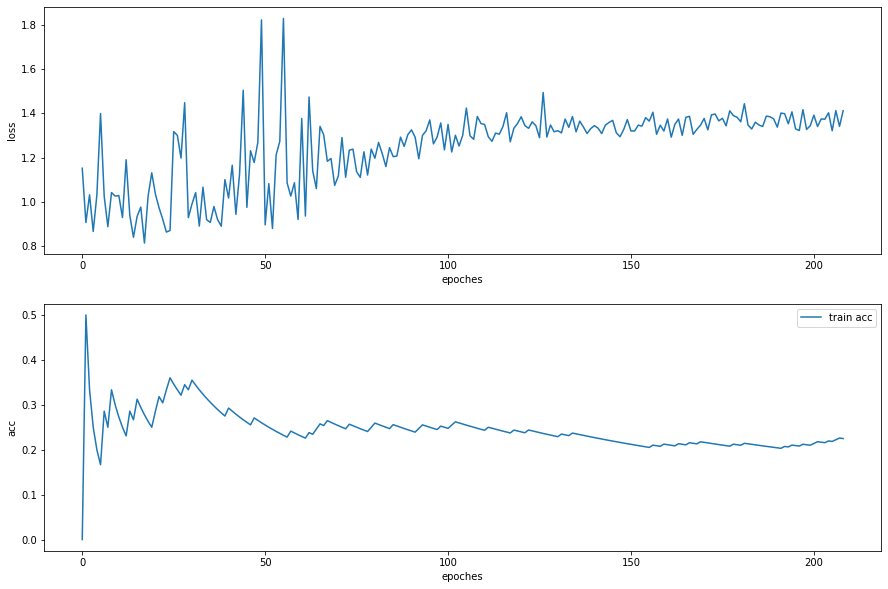

In [45]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(train_loss_5, label = 'train loss')
ax2.plot(train_acc_5, label = 'train acc')
plt.legend()
ax1.set_xlabel('epoches')
ax1.set_ylabel('loss')
ax2.set_xlabel('epoches')
ax2.set_ylabel('acc')


In [46]:
test_loss_5 = []
test_acc_5 = []
n_correct = 0 
n_wrong = 0

model.load_state_dict(torch.load('roberta-model_with_supervised_contrasive_loss.pt'))

for epoch in range(1):  # loop over the dataset multiple times
    
    running_loss = 0.0
    with torch.no_grad():
        for (idx, batch) in enumerate(test_loader):
            sentence = batch["Text"]
            inputs = tokenizer(sentence,padding=True,truncation=True,return_tensors="pt")
            inputs = {k:v.to(device) for k,v in inputs.items()}

            # map string labels to class idex
            labels = [label_maps[stringtoId] for stringtoId in (batch['Class'])]


            # convert list to tensor
            labels = torch.tensor(labels).unsqueeze(0)
            labels = labels.to(device)


            #(batch_size, seq_len)
            #print(inputs["input_ids"].shape)

             # zero the parameter gradients
#             optimizer.zero_grad()

            outputs = model(**inputs,labels=labels,output_hidden_states=True)     

            hidden_states = outputs.hidden_states

            last_hidden_states = hidden_states[12]

            # https://stackoverflow.com/questions/63040954/how-to-extract-and-use-bert-encodings-of-sentences-for-text-similarity-among-sen 
            # (batch_size,seq_len,embed_dim)
            h = last_hidden_states[:,0,:]

            # create pair samples
            T, h_i, h_j, idx_yij = create_supervised_pair(h,batch['Class'],debug=False)

            if h_i is None:
                print("skip this batch")
                skip_time +=1
                continue

            # supervised contrastive loss 
            loss_s_cl = supervised_contrasive_loss(h_i, h_j, h, T,temp=temp,idx_yij=idx_yij,debug=False)

            # cross entropy loss
            loss_classify, logits = outputs[:2]

            # loss total
            loss = loss_s_cl + (lamda * loss_classify)

#             loss.backward()
#             optimizer.step()


            pred_class = torch.argmax(logits)
    #         print(pred_class)
            if pred_class in labels:
                n_correct += 1
            else:
                n_wrong += 1
            total_acc_test = (n_correct * 1.0) / (n_correct + n_wrong)

            test_loss_5.append(loss.item())
            test_acc_5.append(total_acc_test)
#             print(f'[{epoch + 1}, {idx}] loss_total: {loss.item()}, loss_s_cl:{loss_s_cl.item()}, loss_classify:{lamda * loss_classify.item()}')
            print(f'[{epoch + 1}, {idx}] \ntest_loss_total: {loss.item():.2f}, \ntest_loss_s_cl:{loss_s_cl.item():.2f}, \ntest_loss_classify:{lamda * loss_classify.item():.2f}, \ntest_accuracy: {total_acc_test*100:.2f} %')
            clear_output(wait=True)  



[1, 769] 
test_loss_total: 1.52, 
test_loss_s_cl:1.51, 
test_loss_classify:0.01, 
test_accuracy: 24.68 %


In [47]:
import pickle

with open("test_loss_5", "wb") as fp:   #Pickling
  pickle.dump(test_loss_5, fp)

with open("test_acc_5", "wb") as fp:   #Pickling
  pickle.dump(test_acc_5, fp)

Text(0, 0.5, 'acc')

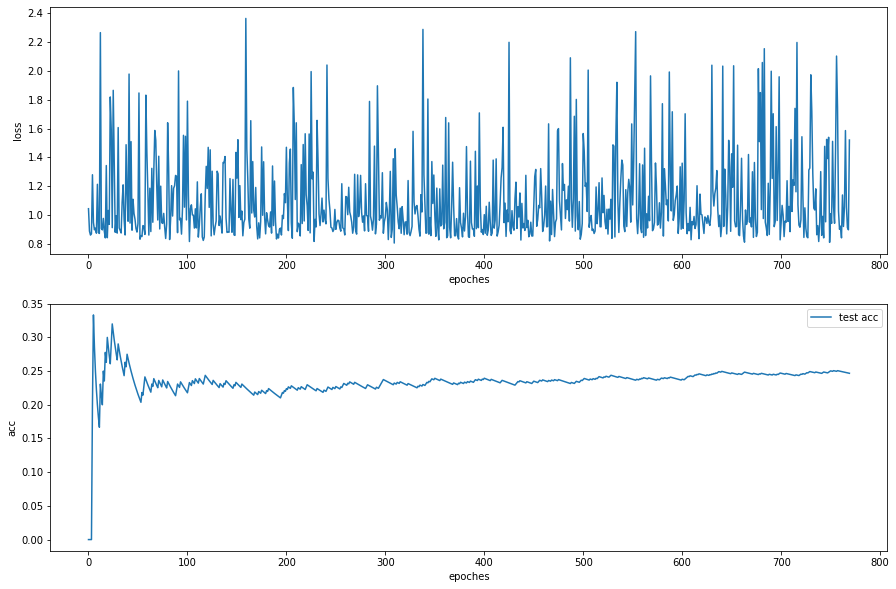

In [48]:
# write code here for 4.5
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(test_loss_5, label = 'test loss')
ax2.plot(test_acc_5, label = 'test acc')
plt.legend()
ax1.set_xlabel('epoches')
ax1.set_ylabel('loss')
ax2.set_xlabel('epoches')
ax2.set_ylabel('acc')


In [49]:
test_loss_5[:5]

[1.0452641248703003,
 0.8898868560791016,
 0.8628239631652832,
 0.8722320795059204,
 1.2800737619400024]

In [50]:
with open("test_loss_5", "rb") as fp:   # Unpickling
  read = pickle.load(fp)
print(read[:5])

[1.0452641248703003, 0.8898868560791016, 0.8628239631652832, 0.8722320795059204, 1.2800737619400024]


In [51]:
model.load_state_dict(torch.load('/content/drive/MyDrive/NLU/roberta-model.pt'))

label_maps_key_list = list(label_maps.keys())
label_maps_val_list = list(label_maps.values())

text = ["I want to deposit", "I want to withdraw", "I want to check account", "I want to transfer money"]
for i in range(len(text)):
  inputs = tokenizer(text[i], return_tensors="pt").to(device)

  with torch.no_grad():
      logits = model(**inputs).logits

  predicted_class_id = logits.argmax().item()
  # predicted_label = model.config.id2label[predicted_class_id]
  # print(predicted_class_id)

  position = label_maps_val_list.index(predicted_class_id)
  print("Text ",i+1,": ",text[i],"\npredicted intent:",label_maps_key_list[position])

Text  1 :  I want to deposit 
predicted intent: balance_not_updated_after_cheque_or_cash_deposit
Text  2 :  I want to withdraw 
predicted intent: atm_support
Text  3 :  I want to check account 
predicted intent: why_verify_identity
Text  4 :  I want to transfer money 
predicted intent: transfer_into_account


In [54]:

model.load_state_dict(torch.load('/content/drive/MyDrive/NLU/roberta-model_with_supervised_contrasive_loss.pt'))

label_maps_key_list = list(label_maps.keys())
label_maps_val_list = list(label_maps.values())

text = ["I want to deposit", "I want to withdraw", "I want to check account", "I want to transfer money"]
for i in range(len(text)):
  inputs = tokenizer(text[i], return_tensors="pt").to(device)

  with torch.no_grad():
      logits = model(**inputs).logits

  predicted_class_id = logits.argmax().item()
  # predicted_label = model.config.id2label[predicted_class_id]
  # print(predicted_class_id)

  position = label_maps_val_list.index(predicted_class_id)
  print("Text ",i+1,": ",text[i],"\npredicted intent:",label_maps_key_list[position])

Text  1 :  I want to deposit 
predicted intent: balance_not_updated_after_cheque_or_cash_deposit
Text  2 :  I want to withdraw 
predicted intent: atm_support
Text  3 :  I want to check account 
predicted intent: why_verify_identity
Text  4 :  I want to transfer money 
predicted intent: transfer_into_account
